## Round Experiment

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [83]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [84]:
from textblob import TextBlob
from wordcloud import WordCloud

In [85]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [86]:
df = pd.read_csv("combined_season1-37.tsv.zip", delimiter='\t')

In [87]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,100,no,LAKES & RIVERS,-,River mentioned most often in the Bible,the Jordan,1984-09-10,-
1,1,200,no,LAKES & RIVERS,-,Scottish word for lake,loch,1984-09-10,-
2,1,800,yes,LAKES & RIVERS,-,River in this famous song:,the Volga River,1984-09-10,-
3,1,400,no,LAKES & RIVERS,-,American river only 33 miles shorter than the ...,the Missouri,1984-09-10,-
4,1,500,no,LAKES & RIVERS,-,"World's largest lake, nearly 5 times as big as...",the Caspian Sea,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389440,2,400,no,FOUNDRY,-,This hefty noisemaker from Whitechapel Foundry...,Big Ben,2021-08-13,-
389441,2,800,no,FOUNDRY,-,"Around 4,000 years ago, the first foundries in...",bronze,2021-08-13,-
389442,2,1200,no,FOUNDRY,-,Several different foundries worked for 4 month...,Monitor,2021-08-13,-
389443,2,1600,no,FOUNDRY,-,"Once one of the largest of its kind, the Gary ...",U.S. Steel,2021-08-13,-


In [88]:
df['air_date'] = pd.to_datetime(df['air_date'])

In [89]:
#On 11/26/2001, the values for the questions doubled for both rounds of Jeopardy. Need to adjust the earlier episodes to have the same values as post-11/26/2001 shows.
df.loc[df['air_date'] < '2001-11-26', "value"] = df.value * 2

In [90]:
#remove Daily Doubles since the contestants can wager any amounts for those
df = df[df["daily_double"] != 'yes']

In [91]:
#keep only standard values (this will remove Final Jeopardy questions, which do not have a set amount and set are at '0', as well as the handful of non-standard values that are likely typos)
df = df.loc[df['value'].isin([200, 400, 600, 800, 1000, 400, 800, 1200, 1600, 2000])]

## NLP Data Cleaning

In [92]:
# import string to remove punctuation

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [93]:
def no_punctuation(text):
    nopunct=[words for words in text if words not in string.punctuation]
    words_without_punct=''.join(nopunct)
    return words_without_punct

In [94]:
#remove punctuation and lowercase words in 'category,' 'answer,' and 'question'

df['category'] = df['category'].apply(lambda x: no_punctuation(x).lower())
df['answer'] = df['answer'].apply(lambda x: no_punctuation(x).lower())
df['question'] = df['question'].apply(lambda x: no_punctuation(x).lower())

In [95]:
#remove numerals from 'category,' 'answer,' and 'question'

df['category'] = df['category'].str.replace('\d+', '')
df['answer'] = df['answer'].str.replace('\d+', '')
df['question'] = df['question'].str.replace('\d+', '')

In [96]:
df

,round,value,daily_double,category,comments,answer,question,air_date,notes
0,1,200,no,lakes rivers,-,river mentioned most often in the bible,the jordan,1984-09-10,-
1,1,400,no,lakes rivers,-,scottish word for lake,loch,1984-09-10,-
3,1,800,no,lakes rivers,-,american river only miles shorter than the mi...,the missouri,1984-09-10,-
4,1,1000,no,lakes rivers,-,worlds largest lake nearly times as big as su...,the caspian sea,1984-09-10,-
5,1,200,no,inventions,-,marconis wonderful wireless,the radio,1984-09-10,-
...,...,...,...,...,...,...,...,...,...
389438,2,1600,no,lost,-,in a moveable feast gertrude stein is quoted a...,lost generation,2021-08-13,-
389440,2,400,no,foundry,-,this hefty noisemaker from whitechapel foundry...,big ben,2021-08-13,-
389441,2,800,no,foundry,-,around years ago the first foundries in mesop...,bronze,2021-08-13,-
389442,2,1200,no,foundry,-,several different foundries worked for months...,monitor,2021-08-13,-


In [97]:
### Make separate data frames for Round 1 and Round 2 questions

In [98]:
round1 = df[df["round"] == 1]

In [99]:
round2 = df[df["round"] == 2]

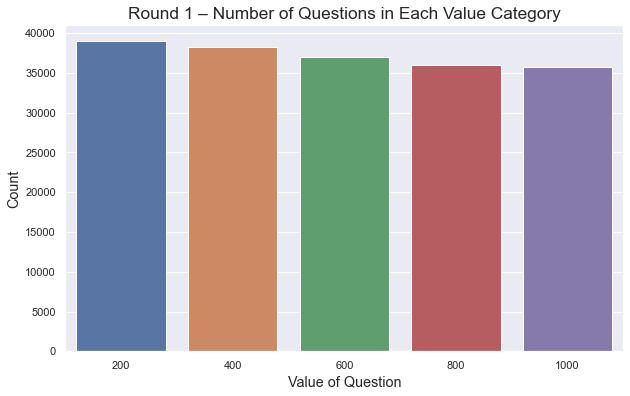

In [130]:
# Visualize the counts of each value category -- Round 1 Questions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=round1, 
    x="value",
    order=round1.value.value_counts().index)

ax.set_title('Round 1 – Number of Questions in Each Value Category',fontsize='x-large')
ax.set_xlabel('Value of Question',fontsize='large')
ax.set_ylabel('Count',fontsize='large')

plt.show();

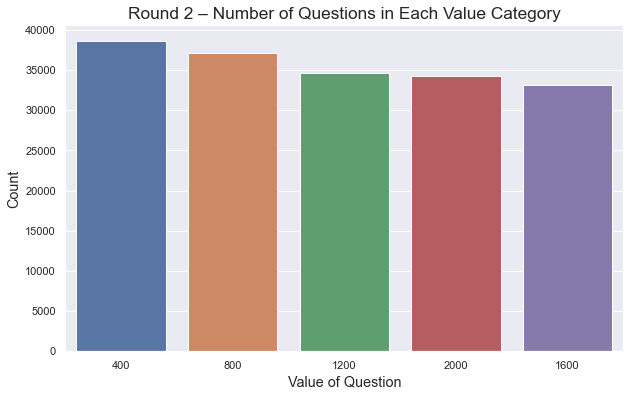

In [129]:
# Visualize the counts of each value category -- Round 2 Questions
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=round2, 
    x="value",
    order=round2.value.value_counts().index)

ax.set_title('Round 2 – Number of Questions in Each Value Category',fontsize='x-large')
ax.set_xlabel('Value of Question',fontsize='large')
ax.set_ylabel('Count',fontsize='large')

plt.show();

In [100]:
X1 = round1['answer']
X2 = round2['answer']
y1 = round1['value']
y2 = round2['value']

In [101]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size= 0.25, random_state=54)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size= 0.25, random_state=54)

In [23]:
# Instantiate the vectorizer with stop words, bigrams, and max_features=50000

tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2), max_features=50000)

# Fit the vectorizer on X1_train and transform it
X1_train_vectorized = tfidf.fit_transform(X1_train)

# Fit the vectorizer on X2_train and transform it
X2_train_vectorized = tfidf.fit_transform(X2_train)

In [24]:
lr = LinearRegression()

In [25]:
lr_regression_cv1 = cross_val_score(lr, X1_train_vectorized, y1_train, cv=3, scoring='neg_root_mean_squared_error')
lr_regression_cv1

array([-429.5761986 , -428.85835113, -432.85157446])

In [26]:
lr_regression_cv1.mean()

-430.42870806364857

In [27]:
lr_regression_cv2 = cross_val_score(lr, X2_train_vectorized, y2_train, cv=3, scoring='neg_root_mean_squared_error')
lr_regression_cv2

array([-875.16115526, -872.3598368 , -870.03583606])

In [28]:
lr_regression_cv2.mean()

-872.5189427053765

In [102]:
# Instantiate the vectorizer with stop words, bigrams, and max_features=50000

tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2), max_features=1000)

# Fit the vectorizer on X1_train and transform it
X1_train_vectorized = tfidf.fit_transform(X1_train)

# Fit the vectorizer on X2_train and transform it
X2_train_vectorized = tfidf.fit_transform(X2_train)

In [104]:
lr_regression_cv1 = cross_val_score(lr, X1_train_vectorized, y1_train, cv=5, scoring='neg_root_mean_squared_error')
lr_regression_cv1

array([-283.24802021, -281.81766982, -282.7863208 , -282.65964418,
       -282.86639484])

In [105]:
lr_regression_cv1.mean()

-282.6756099692069

In [106]:
lr_regression_cv2 = cross_val_score(lr, X2_train_vectorized, y2_train, cv=5, scoring='neg_root_mean_squared_error')
lr_regression_cv2

array([-568.8366432 , -569.38468773, -568.60704314, -566.24848407,
       -568.37249236])

In [107]:
lr_regression_cv2.mean()

-568.2898701010247

In [108]:
both_round_mean = -((lr_regression_cv1.mean() + lr_regression_cv2.mean())/2)

In [109]:
both_round_mean

425.4827400351158

#### Run Round 1 test data and create graph of actual v. predicted

In [110]:
# Round 1--Train the model using the training sets
lr.fit(X1_train_vectorized, y1_train)

LinearRegression()

In [111]:
#Vectorize X1_test
X1_test_vectorized = tfidf.fit_transform(X1_test)

In [112]:
# Make predictions using the test sets
y1_pred = lr.predict(X1_test_vectorized)

In [113]:
round1_linear_test = mean_squared_error(y1_test, y1_pred, squared=False)


285.455889193531

In [115]:
y1_pred.shape

(46480,)

In [116]:
type(y1_pred)

numpy.ndarray

In [117]:
y1_pred

array([577.53864452, 669.94440338, 612.68926091, ..., 620.29389084,
       579.01711441, 622.11642196])

In [118]:
y1_pred = pd.DataFrame(y1_pred, columns = ['Predictions'])
y1_pred

,Predictions
0,577.538645
1,669.944403
2,612.689261
3,515.490671
4,561.662432
...,...
46475,675.424439
46476,665.158210
46477,620.293891
46478,579.017114


In [119]:
y1_test.shape

(46480,)

In [120]:
type(y1_test)

pandas.core.series.Series

In [121]:
y1_test

66244      200
373936     200
287355     400
354429     400
245691    1000
          ... 
296519     200
347390     200
15930     1000
159060    1000
359459     800
Name: value, Length: 46480, dtype: int64

In [122]:
#create a df with actual and predicted y_test values
y1_actual_preds = pd.concat([y1_test.reset_index(drop=True), y1_pred.reset_index(drop=True)], axis=1)

In [123]:
y1_actual_preds

,value,Predictions
0,200,577.538645
1,200,669.944403
2,400,612.689261
3,400,515.490671
4,1000,561.662432
...,...,...
46475,200,675.424439
46476,200,665.158210
46477,1000,620.293891
46478,1000,579.017114


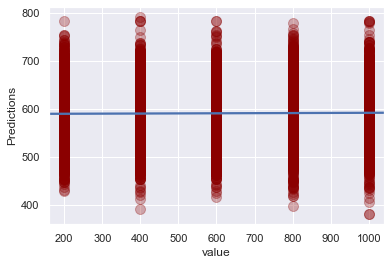

In [142]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=y1_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.3, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_firstround.png');

In [133]:
# Round 2--Train the model using the training sets
lr.fit(X2_train_vectorized, y2_train)

LinearRegression()

In [134]:
#Vectorize X2_test
X2_test_vectorized = tfidf.fit_transform(X2_test)

In [135]:
# Make predictions using the test sets
y2_pred = lr.predict(X2_test_vectorized)

In [137]:
round2_linear_test = mean_squared_error(y2_test, y2_pred, squared=False)
round2_linear_test

574.6388894376832

In [139]:
y2_pred = pd.DataFrame(y2_pred, columns = ['Predictions'])

In [140]:
#create a df with actual and predicted y_test values
y2_actual_preds = pd.concat([y2_test.reset_index(drop=True), y2_pred.reset_index(drop=True)], axis=1)

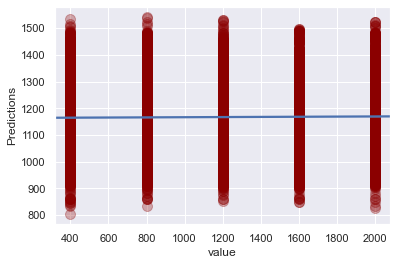

In [143]:
sns.set_theme(style="darkgrid")
sns.regplot(x='value',y='Predictions', data=y2_actual_preds, fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.3, 's': 100}, truncate=False)
plt.savefig('actual_v_predicted_secondround.png');

In [22]:
#Run model against test set

# Train the model using the training sets
max_features1000_regression_model_bigrams.fit(X_train_vectorized10, y_train)

LinearRegression()

In [23]:
#Vectorize X_test
X_test_vectorized10 = tfidf.fit_transform(X_test)

In [24]:
# Make predictions using the testing set
y_pred = max_features1000_regression_model_bigrams.predict(X_test_vectorized10)

In [25]:
rmse_best_linear_test = mean_squared_error(y_test, y_pred, squared=False)

In [26]:
rmse_best_linear_test

536.1847307940411

In [29]:
y_pred.shape

(90942,)

In [63]:
y_pred

array([802.35340959, 990.00974511, 759.73027523, ..., 900.12934979,
       914.40452923, 785.46939034])

In [49]:
type(y_test)

pandas.core.series.Series

In [64]:
y_test

327211     600
213986    1200
277268     400
248430     400
20770      400
          ... 
40678     1600
81440      800
220278     800
338447     400
110947    1000
Name: value, Length: 90942, dtype: int64

In [74]:
round2_linear_test = mean_squared_error(y2_test, y2_pred, squared=False)
round2_linear_test

1729.050432891654

In [ ]:
round2=lr.fit(X2_train_vectorized, y2_train)
X2_test_vectorized = tfidf.fit_transform(X2_test)
y2_pred = lr.predict(X2_test_vectorized)
round2_linear_test = mean_squared_error(y2_test, y2_pred, squared=False)
round2_linear_test

In [29]:
y_pred.shape

(90942,)

In [63]:
y_pred

array([802.35340959, 990.00974511, 759.73027523, ..., 900.12934979,
       914.40452923, 785.46939034])

In [49]:
type(y_test)

pandas.core.series.Series

In [64]:
y_test

327211     600
213986    1200
277268     400
248430     400
20770      400
          ... 
40678     1600
81440      800
220278     800
338447     400
110947    1000
Name: value, Length: 90942, dtype: int64

## Random Forest

In [40]:
#Basic random forest
random_forest = RandomForestRegressor(max_depth=15)
random_forest_cv1 = cross_val_score(random_forest, X1_train_vectorized, y1_train, scoring='neg_root_mean_squared_error', cv=2)

In [41]:
random_forest_cv1

array([-282.50375176, -282.97620315])

In [42]:
random_forest_cv1.mean()

-282.73997745823664

In [43]:
random_forest_cv2 = cross_val_score(random_forest, X2_train_vectorized, y2_train, scoring='neg_root_mean_squared_error', cv=2)
random_forest_cv2

array([-569.34829344, -568.60194399])

In [44]:
random_forest_cv2.mean()

-568.97511871436

In [46]:
both_round_mean_rd = -((random_forest_cv1.mean() + random_forest_cv2.mean())/2)
both_round_mean_rd 

425.85754808629827

In [47]:
tuned_forest = RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_split=4, min_samples_leaf=1, max_features='auto', bootstrap=True)
tuned_forest_cv1 = cross_val_score(tuned_forest, X1_train_vectorized, y1_train, scoring='neg_root_mean_squared_error', cv=2)
tuned_forest_cv1

array([-282.50984018, -282.9512428 ])

In [48]:
tuned_forest_cv1.mean()

-282.7305414896649

In [49]:
tuned_forest_cv2 = cross_val_score(tuned_forest, X2_train_vectorized, y2_train, scoring='neg_root_mean_squared_error', cv=2)
tuned_forest_cv2

array([-569.36795909, -568.69275118])

In [50]:
tuned_forest_cv2.mean()

-569.030355137774

In [51]:
both_round_mean_tuned_rd = -((tuned_forest_cv1.mean() + tuned_forest_cv2.mean())/2)
both_round_mean_tuned_rd

425.88044831371946

In [ ]:
#test if scores change on RF with tweaked tfidf

In [52]:
# Instantiate the vectorizer with stop words, bigrams, and max_features=50000

tfidf = TfidfVectorizer(stop_words='english', ngram_range= (1, 2), max_features=50000)

In [53]:
# Fit the vectorizer on X1_train and transform it
X1_train_vectorized = tfidf.fit_transform(X1_train)

# Fit the vectorizer on X2_train and transform it
X2_train_vectorized = tfidf.fit_transform(X2_train)

In [54]:
random_forest_cv1 = cross_val_score(random_forest, X1_train_vectorized, y1_train, scoring='neg_root_mean_squared_error', cv=2)
random_forest_cv1

array([-282.49877516, -282.88519155])

In [55]:
random_forest_cv1.mean()

-282.69198335501335

In [62]:
random_forest_cv2 = cross_val_score(random_forest, X2_train_vectorized, y2_train, scoring='neg_root_mean_squared_error', cv=2)
random_forest_cv2

array([-569.43767258, -568.33264449])

In [65]:
random_forest_cv2.mean()

-568.8851585342625

In [66]:
both_round_mean_rd = -((random_forest_cv1.mean() + random_forest_cv2.mean())/2)
both_round_mean_rd 

425.78388163756165